In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!curl https://colab.chainer.org/install | sh -
import cupy as cp
import numpy as np

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   7900      0 --:--:-- --:--:-- --:--:--  7900
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 382.9MB 39kB/s 
+ set +ex
Installation succeeded!


In [0]:
import pandas as pd
import seaborn as sns
import pathlib

from skimage.feature import hog
from sklearn.metrics import  precision_score, recall_score, f1_score, classification_report,accuracy_score,confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import six
import sklearn
import time 
import os
import struct
import matplotlib.pyplot as pyplot

In [0]:
#deskew

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)


In [0]:
def read(dataset_img, dataset_lbl=None, path = "."):

    fname_img = os.path.join(path, dataset_img)
    with open(fname_img, 'rb') as fimg:
      magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
      img = np.fromfile(fimg, dtype=np.uint8).reshape(-1, rows, cols)
    if(dataset_lbl is not None):
      fname_lbl = os.path.join(path, dataset_lbl)
      # Load everything in some numpy arrays
      with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)
        get_img = lambda idx: (lbl[idx], img[idx])
    else:
      get_img = lambda idx: (img[idx])
    # Create an iterator which returns each image in turn
    for i in range(len(img)):
      yield get_img(i)

In [0]:
# def convolution(image):
#   ori_img = image
#   kernel = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
#   input_pad = np.pad(ori_img, pad_width=1, mode='constant', constant_values=0) # padding method
#   a = input_pad.shape[0]-kernel.shape[0] + 1 #(30, 3, +1)
#   b = input_pad.shape[1]-kernel.shape[1] + 1 #(30, 3, +1)
#   conv_result = []

#   for rn in range(a):
#       for cn in range(b):
#           result1 = input_pad[rn:rn+kernel.shape[0],cn:cn+kernel.shape[1]] * kernel #[0:0+3,0:0+3] * kernel =  [0:3,0:3] * kernel
#           conv_result.append(np.sum(result1))

#   conv_img = np.array(conv_result).reshape(a,b)
#   #print("result", con_img)
#   return conv_img


In [0]:
class MySVMSGD(BaseEstimator, ClassifierMixin):
  def __init__(self, C=0.1, learning_rate=0.001, batch_size=1,max_iter=25, epsilon=1e-8,random_state=None):
    self.C = C
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.max_iter = max_iter
    self.epsilon = epsilon
    self.random_state = random_state
    self.rgen = np.random.RandomState(self.random_state)
    
    
  def fit(self, X, y):
    self.num_classes = len(cp.unique(y))
    n = np.shape(X)[1]
    #print('n', n )
    self.w_ = cp.array(np.random.randn(n, self.num_classes)) # (784, 10)
    self.b_ = cp.array(np.random.randn(1, self.num_classes))# (1, 10)

    # 한번 해보겠읍니다
    self.min_cost = 1000
    self.best_w = self.w_
    self.best_b = self.b_

    avg_cost =0

    count = 1
    encoded_y = self.one_hot_encode(y)  #y = (60000,) y_changed = (60000, 10)
    #print('encoded_y is ', encoded_y.shape)
    plt_cost = []
    plt_batch = []

    for epoch in range(self.max_iter):
      X_shuffled, y_shuffled = self._shuffle(X,encoded_y) #shuffle 

      # print('type of shuffled data', type(X_shuffled))

      batch_count = int(np.ceil(np.shape(X)[0] / self.batch_size)) #add 1 so 0.x doesn't erase or u could use np.ceil func
      temp_min_cost = 1000
      temp_best_w = self.w_
      temp_best_b = self.b_

      for i in range(batch_count):
        X_batch, y_batch, bs = self.next_batch(X_shuffled, y_shuffled, i)

        X_batch = cp.reshape(X_batch, (bs, n))
        y_batch = cp.reshape(y_batch, (bs, self.num_classes))
        val = self.net_input(X_batch)
        
        cost = self.cost_function(y_batch, val)
        self.update_weight(X_batch, y_batch, val, bs, count)


        avg_cost = avg_cost + cost
        count = count + 1

      avg_cost = avg_cost/batch_count
      temp_min_cost = avg_cost
      # if(epoch>150):
      #   plt_batch.append(epoch)
      #   plt_cost.append(avg_cost)

      if(self.min_cost > temp_min_cost): #before > now 
        self.min_cost = temp_min_cost
        self.best_w = temp_best_w
        self.best_b = temp_best_b
      # print('type of shuffled data', type(X_shuffled))
    return self

  def one_hot_encode(self, y): #one hot encoding 
    encoded_y = cp.ones((np.shape(y)[0], self.num_classes))

    for i in range(self.num_classes):
      encoded_y[:,i][y != i] = -1

    return encoded_y

  def _shuffle(self, X, y = None):
    r = self.rgen.permutation(len(y))
    return X[r], y[r]

  def net_input(self, X):
    #return(X.dot(self.w_) + self.b_)
    return(cp.matmul(X,self.w_) + self.b_)
  
  def next_batch(self, X, y, i):
    ''' getting next batch = getting next data set using np slicing
    for SGD, just pick one data
    if it has batch_size, use batch size to slice data
    '''
    number_sample_data = np.shape(X)[0]
    X_batch = X[i * self.batch_size : min(number_sample_data, (i+1) * self.batch_size)] # 0*25 ~ 1~25 = [0:24], [25,49] ... k 
    y_batch = y[i * self.batch_size : min(number_sample_data, (i+1) * self.batch_size)]
    X_batch = cp.array(X_batch)
    y_batch = cp.array(y_batch)
    bs = min(number_sample_data, (i + 1) * self.batch_size) - i * self.batch_size # batch size
    return X_batch, y_batch, bs

  def cost_function(self, y, val):
    cost_val = 1 - cp.multiply(y, val)

    cost_val[cost_val < 0] = 0 
    cost = cp.mean(cost_val)
    return cost

  def update_weight(self, X, y, val, bs,count):
    '''
    X : (batch_size, 784)
    y : (batch_size, 1)
    val : class score 
    '''
    dw = cp.zeros(self.w_.shape)
    db = cp.zeros(self.b_.shape)
    val = cp.reshape(val, (bs, self.num_classes))
    temp = cp.multiply(y, val) #Z = before yx val
    temp = 1 - temp

    temp[temp <= 0] = 0
    temp[temp > 0] = 1 

    y_temp = cp.multiply(y, temp.reshape(bs, self.num_classes))

    # dw = -(1/bs) * np.dot(X.T, y_temp) +(1/self.C) *self.best_w #keep best?
    # dw = -(1/bs) * X.T.dot(y_temp) +(1/self.C) *self.w_ #keep best 안함
    # db = -(1/bs) * y_temp.sum(axis=0) #axis 0 means sum of row val

    dw = -(1/bs) * cp.matmul(X.T, y_temp) +(1/self.C) *self.w_ #keep best
    db = -(1/bs) * cp.sum(y_temp, axis=0) #axis 0 means sum of row val

    # self.w_ = self.best_w - (self.learning_rate/(1+self.epsilon*count)) * dw # keep best?
    self.w_ = self.w_ - (self.learning_rate/(1+self.epsilon*count)) * dw # keep best 안함
    # self.b_ = self.best_b - self.learning_rate * db # keep best?
    self.b_ = self.b_ - self.learning_rate * db # keep best 안함

    return self.w_, self.b_

  def predict(self, X, y=None):
    c_score = self.net_input(X)
    pred_ans = cp.argmax(c_score, axis=1)
    return pred_ans

  def predict_keep(self, X, y=None):
    # c_score = X.dot(self.best_w) + self.best_b
    c_score = cp.matmul(X,self.best_w) + self.best_b
    pred_ans = cp.argmax(c_score, axis=1)
    return pred_ans  

  def score(self, X,y=None):
    pred = self.predict(X, y)
    ans = cp.mean(pred == y)
    return ans

  def score_keep(self, X, y=None):
    pred = self.predict_keep(X,y)
    ans = cp.mean(pred == y)
    return ans

In [0]:
tr = list(read("/gdrive/My Drive/newtrain-images-idx3-ubyte", "/gdrive/My Drive/newtrain-labels-idx1-ubyte")) #D1+D2+new10k = 80000
ts = list(read("/gdrive/My Drive/mnist-new1k-images-idx3-ubyte", "/gdrive/My Drive/mnist-new1k-labels-idx1-ubyte")) #new10k = 10000

images_train = np.array(list(zip(*tr))[1])
labels_train = np.array(list(zip(*tr))[0])

images_test = np.array(list(zip(*ts))[1])
labels_test = cp.array(list(zip(*ts))[0])


In [0]:
images_test.shape

(10000, 28, 28)

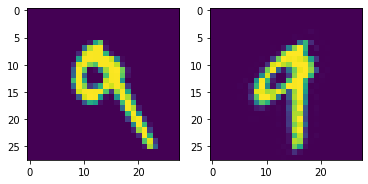

In [0]:
#plot deskewed img
plt.subplot(1, 2, 1)
plt.imshow(images_train[7].reshape(28,28))#change index num if u want to plot other image
newim = deskew(images_train[7].reshape(28,28))#same here
plt.subplot(1, 2, 2)
plt.imshow(newim)

In [0]:
#train-test split
#without deskew

tr_x, ts_x, labels_train, labels_test = train_test_split(images_train,labels_train,test_size=10000)
X_train = tr_x.reshape(-1, 784)
X_test = ts_x.reshape(-1, 784)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
#end here


In [0]:
# #train-test split
# #deskew

# tr_x, ts_x, labels_train, labels_test = train_test_split(images_train,labels_train,test_size=10000)
# X_train = tr_x.reshape(-1, 28, 28)
# X_test = ts_x.reshape(-1, 28, 28)

# X_train_deskewed = deskewAll(X_train)
# X_test_deskewed = deskewAll(X_test)

# scaler = StandardScaler()
# scaler.fit(X_train_deskewed)
# X_train_std = scaler.transform(X_train_deskewed)
# X_test_std = scaler.transform(X_test_deskewed)
# #end here

In [0]:
# #not using train-test split
# #deskew

# # tr_x, ts_x, labels_train, labels_test = train_test_split(images_train,labels_train,test_size=10000)
# X_train = images_train.reshape(-1, 28, 28)
# X_test = images_test.reshape(-1, 28, 28)

# X_train_deskewed = deskewAll(X_train)
# X_test_deskewed = deskewAll(X_test)

# scaler = StandardScaler()
# scaler.fit(X_train_deskewed)
# X_train_std = scaler.transform(X_train_deskewed)
# X_test_std = scaler.transform(X_test_deskewed)
# #end here

In [0]:
pca = PCA(n_components=72)
pca.fit(X_train_std)


X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_pca)[:,1:]
X_test_poly = poly.fit_transform(X_test_pca)[:,1:]

In [0]:
SVMSGDundeskewed2 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=128, max_iter=150, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGDundeskewed2.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGDundeskewed2.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9635
Time takes 246.05626511573792 


In [0]:
SVMSGDundeskewed1 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=150, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGDundeskewed1.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGDundeskewed1.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9649
Time takes 375.6293570995331 


In [0]:
SVMSGDundeskewed = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=32, max_iter=150, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGDundeskewed.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGDundeskewed.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9638
Time takes 635.493631362915 


In [0]:
SVMSGD5 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=150, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD5.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD5.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9942
Time takes 472.25570249557495 


In [0]:
print(SVMSGD5.score_keep(X_test_poly_cp,cp.array(labels_test)))

0.9959


In [0]:
pred = SVMSGD5.predict_keep(cp.array(X_test_poly))

In [0]:
for i in pred:
  print("{0}\n".format(i))

5

0

4

1

9

2

1

3

1

4

3

5

3

6

1

7

2

8

6

9

4

0

9

1

1

2

4

3

2

7

3

8

6

9

0

5

6

0

7

6

1

8

7

9

3

9

8

5

9

3

3

0

7

4

9

8

0

9

4

1

4

4

6

0

4

5

6

1

0

0

1

7

1

6

3

0

2

1

1

7

5

0

2

6

7

8

3

9

0

4

6

7

4

6

8

0

7

8

3

1

5

7

1

7

1

1

6

3

0

2

9

3

1

1

0

4

9

2

0

0

2

0

2

7

1

8

6

4

1

6

3

4

5

9

1

3

3

8

5

4

7

7

4

2

8

5

8

6

9

3

4

6

1

9

9

6

0

3

7

2

8

2

9

4

4

6

4

9

7

0

9

2

7

5

1

5

9

1

2

3

2

3

5

9

1

7

6

2

8

2

2

5

0

7

4

9

7

8

3

2

1

1

8

3

6

1

0

3

1

0

0

1

7

2

7

3

0

4

6

5

2

6

4

7

1

8

9

9

3

0

7

1

0

2

0

3

5

4

6

5

8

6

3

7

5

8

0

9

1

0

3

1

2

2

3

3

6

4

7

5

0

6

2

7

9

8

5

9

2

1

1

4

4

5

6

4

1

2

5

3

9

3

9

0

5

9

6

5

7

4

1

3

4

0

4

8

0

4

3

6

8

7

6

0

9

7

5

7

2

1

1

6

8

9

4

1

5

2

2

9

0

3

9

6

7

2

0

3

5

4

3

6

5

8

In [0]:
SVMSGD5 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=200, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD5.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD5.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9918
Time takes 632.3110482692719 


In [0]:
SVMSGD5 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD5.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD5.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9909
Time takes 159.4939923286438 


In [0]:
SVMSGD5 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=150, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD5.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD5.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9932
Time takes 465.18889594078064 


In [0]:
SVMSGD4 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=32, max_iter=150, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD4.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD4.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9764
Time takes 686.4819436073303 


In [0]:
SVMSGD4 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=32, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD4.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD4.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9763
Time takes 230.59865856170654 


In [0]:
SVMSGD4 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=200, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD4.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD4.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9783
Time takes 556.8138358592987 


In [0]:
SVMSGD3 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=128, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD3.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD3.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9716
Time takes 91.13601064682007 


In [0]:
SVMSGD2 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=128, max_iter=200, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD2.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD2.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9757
Time takes 367.28071570396423 


In [0]:
# labels_test = cp.array(labels_test)
# deskew
SVMSGD = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=512, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9604
Time takes 58.205047607421875 


In [0]:
# labels_test = cp.array(labels_test)
SVMSGD = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=512, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9384
Time takes 58.172847270965576 


In [0]:
#with deskewed image

SVMSGDdeskewed = MySVMSGD(C=1500, learning_rate=0.01, batch_size=512, max_iter=50)
start_time = time.time()
SVMSGDdeskewed.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGDdeskewed.score(X_test_poly_cp,cp.array(labels_test)))
print('Time takes %s '% (time.time() - start_time))



The accuracy of the SVM using PCA&PolynomialFeatures is 0.9117
Time takes 57.67692255973816 


In [0]:
SVMSGD = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=512, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD.score(X_test_poly_cp,labels_test))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9427
Time takes 62.396413803100586 


In [0]:
SVMSGD2 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=512, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD2.fit(X_train_poly, labels_train)
X_test_poly_cp = cp.array(X_test_poly)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD2.score(X_test_poly_cp,labels_test))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9375
Time takes 62.071125507354736 
